In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,AdamOptimizer,MomentumOptimizer,QNGOptimizer
from sklearn.preprocessing import scale, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
# %matplotlib qt
from skimage.transform import resize

ModuleNotFoundError: No module named 'pennylane'

In [2]:
# Load Data Set into test_set and training_set. Then flatten the image into a 1-D array and reduce values to 
# 
batch_size = 64
imsize = 16
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)
train_images_resize = tf.image.resize(train_images, [imsize,imsize]).numpy()
train_images_resize= train_images_resize.reshape(60000, imsize**2)
train_images_resize = train_images_resize/255
mnist_dataset = normalize(train_images_resize[:20000])
train_labels = train_labels[:20000]

2022-02-10 12:47:24.486289: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW


In [3]:
mnist_dataset.shape

(20000, 256)

In [4]:
# PCA on the dataset k > 2 
k=4
pca = PCA(n_components=k)

print("Fitting Data....")
# pca.fit(iris_dataset)
pca.fit(mnist_dataset)
# print("Mean = ", pca.mean_)
print("Variance Ratio = ", pca.explained_variance_ratio_)
print("Variance Ratio Cumulative = ", sum(pca.explained_variance_ratio_))
# print("Components = ", pca.components_)
# X = pca.transform(iris_dataset)
X = pca.transform(mnist_dataset)

number1 = 1
# number2 = 8
valid_labels = train_labels == number1  # Pick a number / species for the real distribution
# valid_labels += train_labels == number2

number_ind = [i for i, e in enumerate(train_labels) if e == number1]

Fitting Data....
Variance Ratio =  [0.10873812 0.07881586 0.06815813 0.0555835 ]
Variance Ratio Cumulative =  0.31129560247063637


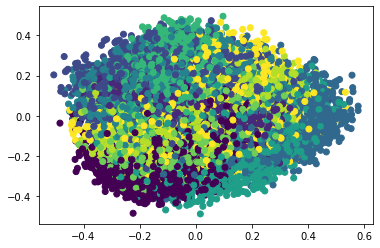

In [5]:
plt.scatter(X[:,2], X[:,3],c=train_labels)
plt.show()

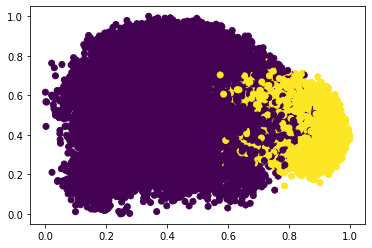

In [6]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1],c=valid_labels)
plt.show()

In [7]:
x_in = []
for i in range(len(number_ind)):
    x_in.append(X[number_ind[i]])
    
print("Number of Real Data = ", len(x_in))

Number of Real Data =  2281


In [8]:
# Extract relavant data from the dataset
pca_data = 2*np.arcsin(np.sqrt(x_in)) 
print(x_in)

[array([0.85350984, 0.31613237, 0.270374  , 0.5766175 ], dtype=float32), array([0.6910622 , 0.62152416, 0.7315668 , 0.555818  ], dtype=float32), array([0.7753164 , 0.62493414, 0.6792639 , 0.44228792], dtype=float32), array([0.8181618 , 0.56541985, 0.6287433 , 0.45533887], dtype=float32), array([0.8390262 , 0.34915447, 0.2656843 , 0.60580975], dtype=float32), array([0.58730537, 0.4180816 , 0.44273764, 0.4610229 ], dtype=float32), array([0.93722224, 0.56245804, 0.6252536 , 0.4380272 ], dtype=float32), array([0.8724667 , 0.25021803, 0.32558602, 0.5571163 ], dtype=float32), array([0.96590376, 0.41331905, 0.42849573, 0.56516993], dtype=float32), array([0.5989467 , 0.35358077, 0.671312  , 0.54350734], dtype=float32), array([0.8752195 , 0.52536416, 0.5664458 , 0.49814883], dtype=float32), array([0.9346133 , 0.3053511 , 0.39406222, 0.53368443], dtype=float32), array([0.8964356 , 0.4799571 , 0.32382736, 0.6040375 ], dtype=float32), array([0.9071679 , 0.45283738, 0.37478155, 0.54156864], dtype=f

In [9]:
# x_not = np.concatenate((X[0:species_ind[0]],X[species_ind[len(species_ind)-1] + 1:len(X)]))
# np.random.shuffle(x_not)
# pca_not_data = 2*np.arcsin(np.sqrt(x_not)) 

In [10]:
dev = qml.device("default.qubit", wires= 2 * k + 1)
gen_dev = qml.device("default.qubit", wires=k)

In [11]:
def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires= k + i)

In [12]:
def generator_sample(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires=h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[l-1, l])
            
def generator(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires= k + h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires= k + j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[k+(l-1), k + l])

In [13]:
def discriminator(w):
    W = np.reshape(w, (layers, k))
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
#         if i % 2 == 0:
        for l in range(1, len(W[i])):
            qml.CNOT(wires=[l-1, l])

In [14]:
# For real data set
@qml.qnode(dev)
def real_disc_circuit(x_in_l, disc_weights):
    qml.Hadamard(wires= 2 * k)
    discriminator(disc_weights)
    real(x_in_l)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# For Generated data set
@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    qml.Hadamard(wires= 2 * k)
    generator(gen_weights)
    discriminator(disc_weights)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# Exract Synthetic data from Generator:
gen_dev.shots = 20
@qml.qnode(gen_dev)
def gen_data(gen_weights):
    generator_sample(gen_weights)
    exp = [qml.sample(qml.PauliZ(i)) for i in range(k)]
    return exp

In [15]:
def prob_real_true(x_in_l, disc_weights):
    true_disc_output = real_disc_circuit(x_in_l, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

# def prob_fakeReal_true(x_in_f, disc_weights):
#     fake_disc_output = real_disc_circuit(x_in_f, disc_weights)
#     # convert to probability
#     prob_fake_true = (fake_disc_output + 1) / 2
#     return prob_fake_true

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true  # generator wants to minimize this prob


def disc_cost(x_in_l, gen_weights, disc_weights):
    cost = 0
    for i in range(len(x_in_l)):
        cost += prob_fake_true(gen_weights, disc_weights) - prob_real_true(x_in_l[i], disc_weights)
#         cost += -1 * (np.log(1 - prob_fake_true(gen_weights, disc_weights)) + np.log(prob_real_true(x_in_l[i], disc_weights)))
    return cost / len(x_in_l)


def gen_cost(gen_weights, disc_weights):
    cost = 0
    for i in range(batch_size):
        cost += prob_fake_true(gen_weights, disc_weights)
#         cost += np.log(1 - prob_fake_true(gen_weights, disc_weights))
    return -(cost / batch_size)

In [16]:
# np.random.seed(2)
layers = 4
eps = 1e-2
mulpt = 2
gen_weights = np.array([np.pi] + [0] * (layers * k - 1)) + np.random.normal(scale=eps, size=[layers * k])
disc_weights = np.random.normal(size=[k * layers])
drawer = qml.draw(real_disc_circuit, max_length=100)
print(drawer(x_in[0], disc_weights))

 0: ──RY(-0.847)──╭C───RY(-0.749)──────────────╭C───────────RY(0.289)──────────────╭C───────────RY(
 1: ──RY(2.15)────╰X──╭C────────────RY(0.293)──╰X──────────╭C───────────RY(0.245)──╰X──────────╭C──
 2: ──RY(-2.11)───────╰X───────────╭C───────────RY(0.465)──╰X──────────╭C───────────RY(-1.85)──╰X──
 3: ──RY(0.0594)───────────────────╰X───────────RY(0.407)──────────────╰X───────────RY(0.881)──────
 4: ──RY(0.854)────────────────────────────────────────────────────────────────────────────────────
 5: ──RY(0.316)────────────────────────────────────────────────────────────────────────────────────
 6: ──RY(0.27)─────────────────────────────────────────────────────────────────────────────────────
 7: ──RY(0.577)────────────────────────────────────────────────────────────────────────────────────
 8: ──H────────────────────────────────────────────────────────────────────────────────────────────

 0.565)──────────────╭C────────────────╭SWAP──────────────────────────────┤    
 ─────────RY(0.431)

In [17]:
drawer = qml.draw(gen_disc_circuit, max_length=100)
print(drawer(gen_weights, disc_weights))

 0: ──RY(-0.847)──╭C──────────────RY(-0.749)─────────────────╭C─────────────RY(0.289)──────────────
 1: ──RY(2.15)────╰X─────────────╭C────────────RY(0.293)─────╰X────────────╭C──────────────RY(0.245
 2: ──RY(-2.11)──────────────────╰X───────────╭C──────────────RY(0.465)────╰X─────────────╭C───────
 3: ──RY(0.0594)──────────────────────────────╰X──────────────RY(0.407)───────────────────╰X───────
 4: ──H────────────RY(3.15)──────╭C────────────RY(-0.00351)───RY(-0.0111)─────────────────╭C───────
 5: ──H────────────RY(-0.00137)──╰X───────────╭C──────────────RY(-0.0106)───RY(0.0116)────╰X───────
 6: ──H────────────RY(0.0119)─────────────────╰X─────────────╭C─────────────RY(0.005)──────RY(-0.00
 7: ──H────────────RY(0.00195)───────────────────────────────╰X─────────────RY(-0.00653)───RY(-0.00
 8: ──H────────────────────────────────────────────────────────────────────────────────────────────

 ──────╭C─────────────RY(0.565)─────────────────────╭C────────────────╭SWAP────────────────────────

In [18]:
opt = GradientDescentOptimizer(0.05)

Starting Epoch :  0
Step 1: cost = 0.013634992573876662
Step 65: cost = 0.010434993329828508
Step 129: cost = 0.012404627197394158
Step 193: cost = 0.010981143865736573
Step 257: cost = 0.010559569078694929
Step 321: cost = 0.008286966047970648
Step 385: cost = 0.008034946354620187
Step 449: cost = 0.0066171654234555444
Step 513: cost = 0.013782814458653616
Step 577: cost = 0.006614627052036488
Step 641: cost = 0.006773312742873232
Step 705: cost = 0.0014094803585698902
Step 769: cost = 0.004265593681853823
Step 833: cost = 0.008538639646814101
Step 897: cost = 0.0027913619351824827
Step 961: cost = 0.0013854879913327012
Step 1025: cost = 0.0034042747257048787
Step 1089: cost = 0.004168389958137824
Step 1153: cost = -0.0024684024210150333
Step 1217: cost = -0.0015670953954873851
Step 1281: cost = -0.003707549954115921
Step 1345: cost = 0.0006804709266399252
Step 1409: cost = -0.0038353714180826178
Step 1473: cost = -0.0010193096811010882
Step 1537: cost = 0.001046396289830373
Step 1601

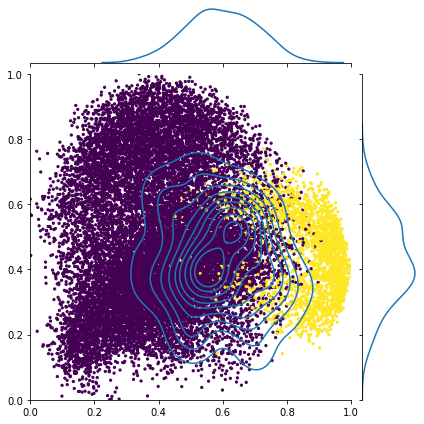

Starting Epoch :  1
Step 1: cost = 0.01143076236716946
Step 65: cost = 0.010686986809151653
Step 129: cost = 0.006457167862866008
Step 193: cost = 0.005379635838378798
Step 257: cost = 0.005744092945684613
Step 321: cost = 0.007717184414046799
Step 385: cost = 0.00586493671574724
Step 449: cost = 0.006323671056060184
Step 513: cost = 0.004995759308585661
Step 577: cost = 0.0016753582520689855
Step 641: cost = 0.0023767096155302113
Step 705: cost = 0.0036893224317904923
Step 769: cost = 0.003964840180837639
Step 833: cost = 0.004439038951843123
Step 897: cost = 0.0020093567533164616
Step 961: cost = -0.0008892951341430439
Step 1025: cost = 0.004248158548307393
Step 1089: cost = -0.001141519894943226
Step 1153: cost = -0.0020475718805999885
Step 1217: cost = -0.0022287115889996698
Step 1281: cost = -0.006082227102802994
Step 1345: cost = -0.002147685152429144
Step 1409: cost = -0.0045483634706185525
Step 1473: cost = -0.0033786266984405927
Step 1537: cost = -0.0034186414376204694
Step 16

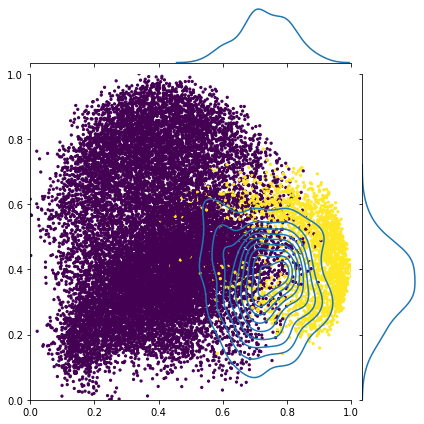

Starting Epoch :  2
Step 1: cost = 0.016983731958592138
Step 65: cost = 0.012640502620091
Step 129: cost = 0.014339816970226335
Step 193: cost = 0.008055742337138046
Step 257: cost = 0.009142571888925432
Step 321: cost = 0.009899524848639374
Step 385: cost = 0.012014783842464365
Step 449: cost = 0.004305559163687748
Step 513: cost = 0.007292106455689805
Step 577: cost = 0.00863163432228835
Step 641: cost = 0.0069007187670692745
Step 705: cost = 0.003318118661766083
Step 769: cost = 0.008894564388981781
Step 833: cost = 0.0014581113815377387
Step 897: cost = 0.004689461962448207
Step 961: cost = 0.004232831593425634
Step 1025: cost = 0.0031404461828527224
Step 1089: cost = 0.0034288399334520946
Step 1153: cost = 0.00315783829485153
Step 1217: cost = 0.001621738561551931
Step 1281: cost = 7.714365482610654e-05
Step 1345: cost = -0.0009781118628322295
Step 1409: cost = 0.0002534646778418661
Step 1473: cost = 0.0005876727058803429
Step 1537: cost = -0.0017153109953337905
Step 1601: cost = 

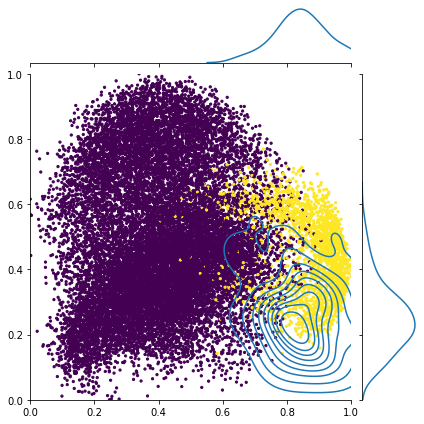

Starting Epoch :  3
Step 1: cost = 0.027503248542319277
Step 65: cost = 0.02153705202085994
Step 129: cost = 0.02118452179233249
Step 193: cost = 0.020766952862322607
Step 257: cost = 0.02345243165703923
Step 321: cost = 0.019706809483210023
Step 385: cost = 0.016573069892753412
Step 449: cost = 0.0186673224832465
Step 513: cost = 0.014588657801965652
Step 577: cost = 0.013476958430779633
Step 641: cost = 0.016473757841492437
Step 705: cost = 0.01298088824998102
Step 769: cost = 0.012856841139489943
Step 833: cost = 0.009623406357259444
Step 897: cost = 0.011666900254313042
Step 961: cost = 0.010366980869855715
Step 1025: cost = 0.009956808199584588
Step 1089: cost = 0.011411716599211436
Step 1153: cost = 0.011326283325142277
Step 1217: cost = 0.00911671270946461
Step 1281: cost = 0.008015540379127948
Step 1345: cost = 0.007539588094564854
Step 1409: cost = 0.005072326058620829
Step 1473: cost = 0.005188314035021855
Step 1537: cost = 0.007563830629684269
Step 1601: cost = 0.00442303979

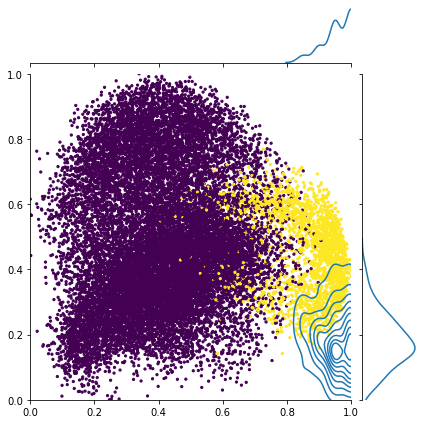

Starting Epoch :  4
Step 1: cost = 0.03645540231280463
Step 65: cost = 0.03260445918661858
Step 129: cost = 0.03276623592501157
Step 193: cost = 0.033408990054196216
Step 257: cost = 0.029687323505347016
Step 321: cost = 0.029186607320180347
Step 385: cost = 0.02819335013240461
Step 449: cost = 0.029174860815761323
Step 513: cost = 0.02645219088536676
Step 577: cost = 0.025703444811720603
Step 641: cost = 0.023561422071066068
Step 705: cost = 0.025929585477194782
Step 769: cost = 0.023330936980754988
Step 833: cost = 0.020522494395676768
Step 897: cost = 0.021964917294902166
Step 961: cost = 0.020139226014718112
Step 1025: cost = 0.017937835915761098
Step 1089: cost = 0.01834386006989397
Step 1153: cost = 0.018160985246739435
Step 1217: cost = 0.01655183105228413
Step 1281: cost = 0.015246216317861161
Step 1345: cost = 0.01667422592564558
Step 1409: cost = 0.010962214879911766
Step 1473: cost = 0.014239110803004829
Step 1537: cost = 0.013628964704620123
Step 1601: cost = 0.012219966433

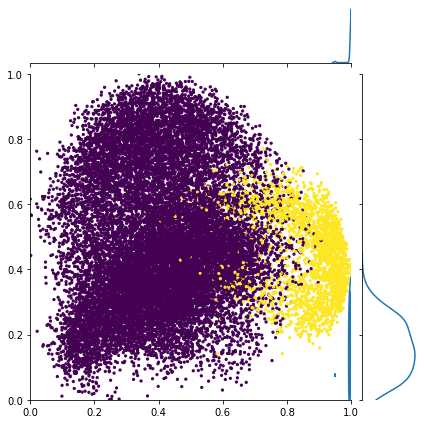

Starting Epoch :  5
Step 1: cost = 0.041198533348075744
Step 65: cost = 0.04332834972547556
Step 129: cost = 0.0416603119022326
Step 193: cost = 0.03987290959330252
Step 257: cost = 0.03897630649238294
Step 321: cost = 0.038998998662082895
Step 385: cost = 0.03712588437521823
Step 449: cost = 0.03613202568879614
Step 513: cost = 0.036486601352469
Step 577: cost = 0.0373487130189623
Step 641: cost = 0.03298598715274202
Step 705: cost = 0.033499351572926245
Step 769: cost = 0.032471451060825204
Step 833: cost = 0.029629862192615666
Step 897: cost = 0.02997370113526977
Step 961: cost = 0.028701767223948287
Step 1025: cost = 0.0259980724033493
Step 1089: cost = 0.027527933686920285
Step 1153: cost = 0.024886784749122277
Step 1217: cost = 0.027168968518819475
Step 1281: cost = 0.02518513383835036
Step 1345: cost = 0.02470199913823005
Step 1409: cost = 0.021182635175529797
Step 1473: cost = 0.02036128538926469
Step 1537: cost = 0.019682489657749186
Step 1601: cost = 0.02101944890554555
Step 

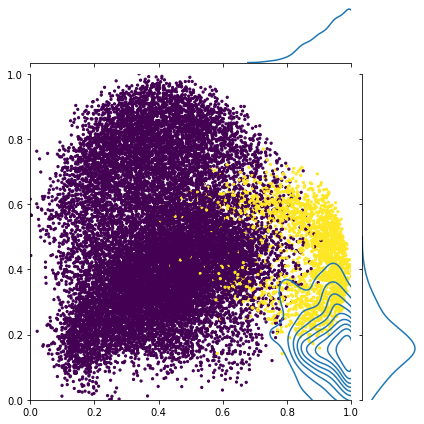

Starting Epoch :  6
Step 1: cost = 0.04885332720179614
Step 65: cost = 0.048512916717034324
Step 129: cost = 0.04828312008419085
Step 193: cost = 0.04697703268723439
Step 257: cost = 0.04604208112881986
Step 321: cost = 0.045858450111959916
Step 385: cost = 0.04365315863403098
Step 449: cost = 0.04431816673398209
Step 513: cost = 0.04326487921348344
Step 577: cost = 0.042831839383012014
Step 641: cost = 0.04010938230084028
Step 705: cost = 0.03918670347611114
Step 769: cost = 0.03904704402936874
Step 833: cost = 0.03752999034764971
Step 897: cost = 0.0378143352651677
Step 961: cost = 0.03621581560973223
Step 1025: cost = 0.03568096927736569
Step 1089: cost = 0.03223968476323116
Step 1153: cost = 0.03380729987902616
Step 1217: cost = 0.032389666659896864
Step 1281: cost = 0.032268276674844124
Step 1345: cost = 0.03191799926761551
Step 1409: cost = 0.031224986447029004
Step 1473: cost = 0.02980805628134868
Step 1537: cost = 0.02805601507662696
Step 1601: cost = 0.02819213502255695
Step 1

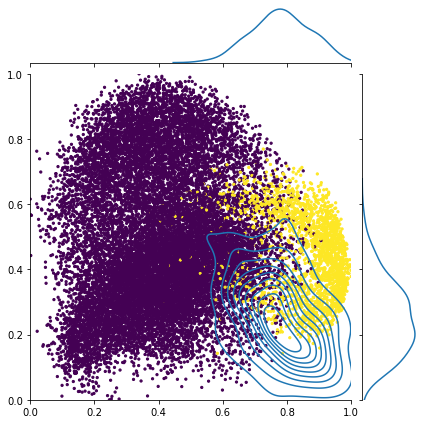

Starting Epoch :  7
Step 1: cost = 0.05716587331507548
Step 65: cost = 0.05493610100068753
Step 129: cost = 0.0532983606101943
Step 193: cost = 0.051175018973966827
Step 257: cost = 0.05081163009802703
Step 321: cost = 0.0486032436649818
Step 385: cost = 0.04874064013164625
Step 449: cost = 0.04767507467071521
Step 513: cost = 0.047362991502902824
Step 577: cost = 0.04531611812502728
Step 641: cost = 0.0446888815410917
Step 705: cost = 0.04306622066201375
Step 769: cost = 0.04228055583347341
Step 833: cost = 0.04106965870859092
Step 897: cost = 0.04165974321542748
Step 961: cost = 0.03959469018196388
Step 1025: cost = 0.03861330614234905
Step 1089: cost = 0.03825603017419148
Step 1153: cost = 0.03524605658870014
Step 1217: cost = 0.03593789309535439
Step 1281: cost = 0.034326767224962904
Step 1345: cost = 0.03513662675752624
Step 1409: cost = 0.033578149809668875
Step 1473: cost = 0.031879160247041016
Step 1537: cost = 0.0307302035044993
Step 1601: cost = 0.030916234123249092
Step 1665

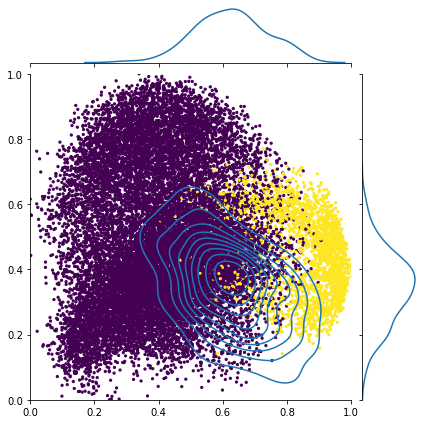

Starting Epoch :  8
Step 1: cost = 0.05717197137648462
Step 65: cost = 0.05526624928884251
Step 129: cost = 0.05218492716026307
Step 193: cost = 0.05079879862011502
Step 257: cost = 0.04867787971764484
Step 321: cost = 0.04721350098705352
Step 385: cost = 0.04591877792769269
Step 449: cost = 0.043906309542023444
Step 513: cost = 0.04416584652965283
Step 577: cost = 0.04154202669606229
Step 641: cost = 0.04175228332528069
Step 705: cost = 0.03935950576543177
Step 769: cost = 0.03903336735109434
Step 833: cost = 0.037785842120618106
Step 897: cost = 0.03705693537666883
Step 961: cost = 0.0349464074797805
Step 1025: cost = 0.03464490234158345
Step 1089: cost = 0.03439702196929051
Step 1153: cost = 0.03258811908105458
Step 1217: cost = 0.031310058447562086
Step 1281: cost = 0.03077695508499207
Step 1345: cost = 0.030383831704484665
Step 1409: cost = 0.02824544961038221
Step 1473: cost = 0.0285623307822378
Step 1537: cost = 0.026617350526285007
Step 1601: cost = 0.02640821011730763
Step 166

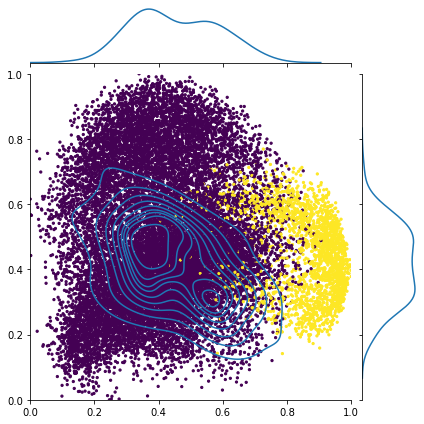

Starting Epoch :  9
Step 1: cost = 0.04498016160172104
Step 65: cost = 0.043094495948570115
Step 129: cost = 0.04129522306231015
Step 193: cost = 0.03941516960597343
Step 257: cost = 0.038232050853426985
Step 321: cost = 0.03672599321815545
Step 385: cost = 0.03472842887486782
Step 449: cost = 0.03382157429320055
Step 513: cost = 0.03279840714223693
Step 577: cost = 0.0313483172544929
Step 641: cost = 0.03009579155978717
Step 705: cost = 0.028864141269548248
Step 769: cost = 0.027860639561351187
Step 833: cost = 0.026717930990236276
Step 897: cost = 0.025807049084310855
Step 961: cost = 0.02460127842972098
Step 1025: cost = 0.023734932877146356
Step 1089: cost = 0.022759062038450628
Step 1153: cost = 0.0218649659084124
Step 1217: cost = 0.02089844151611906
Step 1281: cost = 0.020037532834924487
Step 1345: cost = 0.019152593580827784
Step 1409: cost = 0.018322205925060488
Step 1473: cost = 0.01750227679648335
Step 1537: cost = 0.016694183012647953
Step 1601: cost = 0.015853637776365465


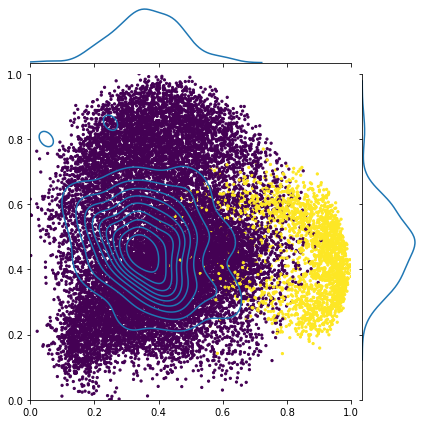

Starting Epoch :  10
Step 1: cost = 0.024544128272318645
Step 65: cost = 0.023227546549100066
Step 129: cost = 0.022196915438773286
Step 193: cost = 0.02084876290335435
Step 257: cost = 0.019713833870100193
Step 321: cost = 0.018367391261431724
Step 385: cost = 0.017024921763433974
Step 449: cost = 0.016172686248794248
Step 513: cost = 0.01494091059247965
Step 577: cost = 0.014535223871636381
Step 641: cost = 0.01373704098553963
Step 705: cost = 0.012302037270777593
Step 769: cost = 0.011798388656896861
Step 833: cost = 0.01075358607669305
Step 897: cost = 0.009349847544826751
Step 961: cost = 0.00860477784669332
Step 1025: cost = 0.00820971922251111
Step 1089: cost = 0.006592489524119021
Step 1153: cost = 0.006829591398827819
Step 1217: cost = 0.005958901823525417
Step 1281: cost = 0.005984693839953977
Step 1345: cost = 0.0053543255023935435
Step 1409: cost = 0.0038953853123043433
Step 1473: cost = 0.0028557643399525524
Step 1537: cost = 0.001850195931558116
Step 1601: cost = 0.001709

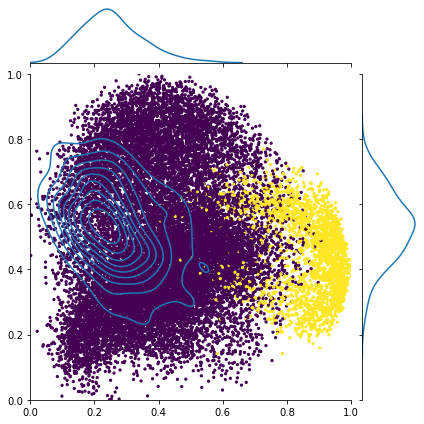

Starting Epoch :  11
Step 1: cost = 0.0017853605217877933
Step 65: cost = 0.0008834985228434022
Step 129: cost = 0.0006933207548262647
Step 193: cost = -0.0004712955866586054
Step 257: cost = -0.0018408420459738346
Step 321: cost = -0.0023625840037674022
Step 385: cost = -0.0027800611229401827
Step 449: cost = -0.0037794181052296823
Step 513: cost = -0.00415734868528965
Step 577: cost = -0.0053301915272731155
Step 641: cost = -0.00622740455071007
Step 705: cost = -0.007202346078574595
Step 769: cost = -0.006626559142581683
Step 833: cost = -0.00735732980195975
Step 897: cost = -0.009392072635162993
Step 961: cost = -0.009526236515115142
Step 1025: cost = -0.009654605607295547
Step 1089: cost = -0.010465557455048378
Step 1153: cost = -0.011040432722511857
Step 1217: cost = -0.010816279507810861
Step 1281: cost = -0.012347615897426877
Step 1345: cost = -0.012190047153762847
Step 1409: cost = -0.011792314709643896
Step 1473: cost = -0.012964836842029755
Step 1537: cost = -0.01399714374054

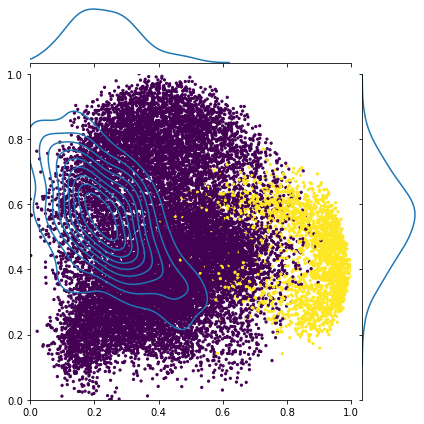

Starting Epoch :  12
Step 1: cost = -0.02096851574188277
Step 65: cost = -0.021754735697520372
Step 129: cost = -0.022270592724653746
Step 193: cost = -0.022361020304471756
Step 257: cost = -0.022922844942142563
Step 321: cost = -0.024171726479854612
Step 385: cost = -0.024948221787715455
Step 449: cost = -0.024350615036867362
Step 513: cost = -0.024097213287368253
Step 577: cost = -0.02600660183064465
Step 641: cost = -0.02728544335577881
Step 705: cost = -0.026140503507562023
Step 769: cost = -0.028088215308858386
Step 833: cost = -0.02891945385742533
Step 897: cost = -0.028897153579392675
Step 961: cost = -0.029956305729310247
Step 1025: cost = -0.030269757290115717
Step 1089: cost = -0.03221642233611546
Step 1153: cost = -0.03218804734194784
Step 1217: cost = -0.03274089446509669
Step 1281: cost = -0.030857035529810395
Step 1345: cost = -0.033079074850109386
Step 1409: cost = -0.03376960688366801
Step 1473: cost = -0.034681691686888734
Step 1537: cost = -0.033920869805327214
Step 1

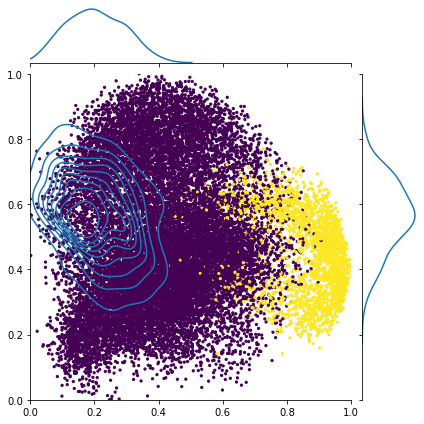

Starting Epoch :  13
Step 1: cost = -0.04430069328871733
Step 65: cost = -0.044953353725587994
Step 129: cost = -0.04560719460248297
Step 193: cost = -0.046262423157078
Step 257: cost = -0.04619669392970968
Step 321: cost = -0.047207179818753275
Step 385: cost = -0.04702148687803452
Step 449: cost = -0.04888003970140661
Step 513: cost = -0.049061981187609474
Step 577: cost = -0.04819592155256677
Step 641: cost = -0.0491145437211707
Step 705: cost = -0.048971138418104423
Step 769: cost = -0.04986778790546887
Step 833: cost = -0.05001707813146226
Step 897: cost = -0.05028165507704367
Step 961: cost = -0.05270185373106374
Step 1025: cost = -0.053487371156050845
Step 1089: cost = -0.05188053866152146
Step 1153: cost = -0.05467580631091176
Step 1217: cost = -0.05504458820764206
Step 1281: cost = -0.055202716516454566
Step 1345: cost = -0.0560044019477143
Step 1409: cost = -0.05669945891932954
Step 1473: cost = -0.05800864732365981
Step 1537: cost = -0.056882536303181616
Step 1601: cost = -0

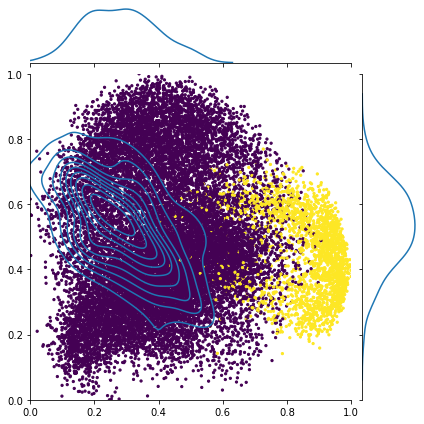

Starting Epoch :  14
Step 1: cost = -0.06501079331587889
Step 65: cost = -0.0656817404185982
Step 129: cost = -0.06635728501298438
Step 193: cost = -0.06703737000931159
Step 257: cost = -0.06772193541239091
Step 321: cost = -0.0679438592376322
Step 385: cost = -0.06910111767226604
Step 449: cost = -0.06932560142438624
Step 513: cost = -0.06935328498152508
Step 577: cost = -0.07004217646140504
Step 641: cost = -0.07189574502205974
Step 705: cost = -0.07144026173531737
Step 769: cost = -0.07331860762927622
Step 833: cost = -0.07334423740534984
Step 897: cost = -0.07097010327271674
Step 961: cost = -0.07446812043161591
Step 1025: cost = -0.0749754113726453
Step 1089: cost = -0.07655214801683964
Step 1153: cost = -0.07209045056467757
Step 1217: cost = -0.07675456893826352
Step 1281: cost = -0.07784392926904511
Step 1345: cost = -0.078947934161764
Step 1409: cost = -0.07969020059488899
Step 1473: cost = -0.08005449973326043
Step 1537: cost = -0.0798033062530468
Step 1601: cost = -0.08152819

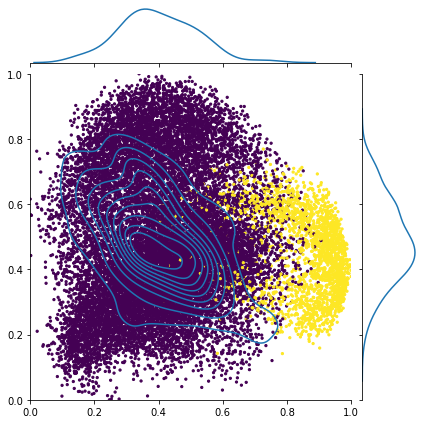

Starting Epoch :  15
Step 1: cost = -0.06657745567886753
Step 65: cost = -0.06738278588487254
Step 129: cost = -0.06818148459994855
Step 193: cost = -0.06897369061614701
Step 257: cost = -0.06975953813689885
Step 321: cost = -0.07053915678862745
Step 385: cost = -0.07131267164241173
Step 449: cost = -0.07208020324501166
Step 513: cost = -0.07284186765860588
Step 577: cost = -0.07217368260515385
Step 641: cost = -0.07434139640009807
Step 705: cost = -0.07508606766655025
Step 769: cost = -0.0758252942562109
Step 833: cost = -0.07655917061506387
Step 897: cost = -0.07728778709298909
Step 961: cost = -0.0780112300279194
Step 1025: cost = -0.07784207004170528
Step 1089: cost = -0.07707410174196169
Step 1153: cost = -0.0789695612513974
Step 1217: cost = -0.07935191029526625
Step 1281: cost = -0.07692519953296957
Step 1345: cost = -0.08070874526286607
Step 1409: cost = -0.08197509963509018
Step 1473: cost = -0.08297513955073557
Step 1537: cost = -0.08089888617752762
Step 1601: cost = -0.08339

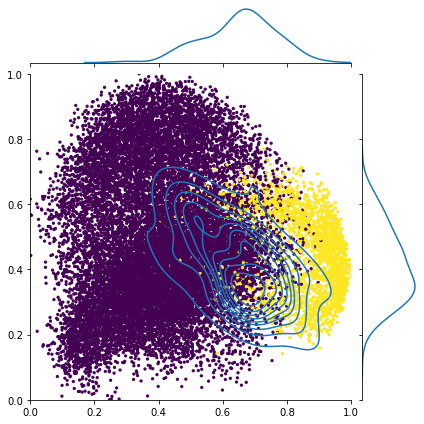

Starting Epoch :  16
Step 1: cost = -0.018312710140661173
Step 65: cost = -0.01924728038656074
Step 129: cost = -0.020167287450682546
Step 193: cost = -0.021072872201073706
Step 257: cost = -0.021964182361538492
Step 321: cost = -0.022841371988085113
Step 385: cost = -0.02370460095961091
Step 449: cost = -0.02455403448347708
Step 513: cost = -0.025389842616529615
Step 577: cost = -0.02621219980203053
Step 641: cost = -0.026062756507126125
Step 705: cost = -0.027816782949549194
Step 769: cost = -0.028599789358492993
Step 833: cost = -0.029370079875756572
Step 897: cost = -0.030127844486199873
Step 961: cost = -0.03087327512901794
Step 1025: cost = -0.03160656535156092
Step 1089: cost = -0.0313676462807638
Step 1153: cost = -0.033037106112891124
Step 1217: cost = -0.033735067984206335
Step 1281: cost = -0.032857917374021134
Step 1345: cost = -0.03509676478294526
Step 1409: cost = -0.03383973816017881
Step 1473: cost = -0.03641403136526675
Step 1537: cost = -0.03705691639758868
Step 1601:

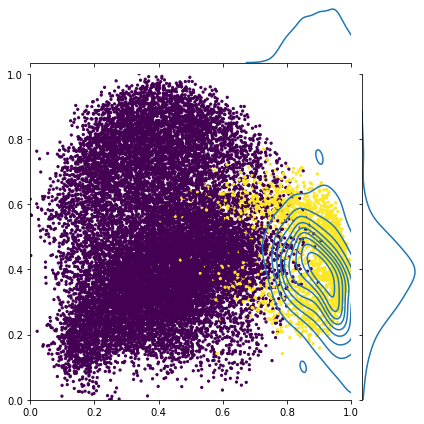

Starting Epoch :  17
Step 1: cost = 0.05883047885497514
Step 65: cost = 0.0578573210601907
Step 129: cost = 0.056891641835623154
Step 193: cost = 0.0559336249821167
Step 257: cost = 0.05498344556275162
Step 321: cost = 0.05404126987001993
Step 385: cost = 0.05310725541126157
Step 449: cost = 0.052181550911828155
Step 513: cost = 0.051264296335382514
Step 577: cost = 0.050355622920700505
Step 641: cost = 0.049455653234305785
Step 705: cost = 0.04856450123824537
Step 769: cost = 0.04768227237226389
Step 833: cost = 0.0468090636496344
Step 897: cost = 0.04594496376587558
Step 961: cost = 0.04509005321957711
Step 1025: cost = 0.044244404444526875
Step 1089: cost = 0.043408081952359054
Step 1153: cost = 0.04258114248492051
Step 1217: cost = 0.041763635175545044
Step 1281: cost = 0.040955601718477286
Step 1345: cost = 0.04015707654562743
Step 1409: cost = 0.04021786339497454
Step 1473: cost = 0.038584262336452735
Step 1537: cost = 0.03781448558911604
Step 1601: cost = 0.03759530659252256
Ste

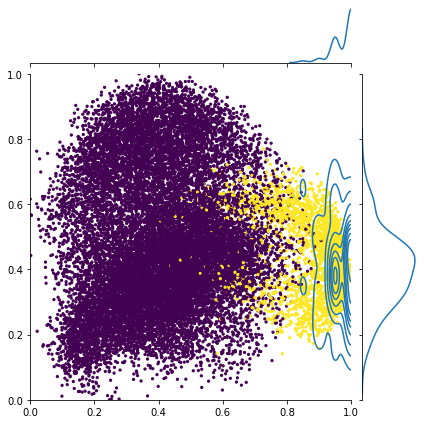

Starting Epoch :  18
Step 1: cost = 0.07924880210234517
Step 65: cost = 0.07791237910877949
Step 129: cost = 0.07658847778497083
Step 193: cost = 0.07527734364180007
Step 257: cost = 0.07397920612984733
Step 321: cost = 0.07269427878757104
Step 385: cost = 0.07142275942031201
Step 449: cost = 0.07016483030815086
Step 513: cost = 0.06892065844061002
Step 577: cost = 0.06769039577616812
Step 641: cost = 0.06647417952459467
Step 705: cost = 0.06527213245006014
Step 769: cost = 0.06408436319307856
Step 833: cost = 0.06291096660929796
Step 897: cost = 0.06175202412324776
Step 961: cost = 0.060607604095177486
Step 1025: cost = 0.05947776219917908
Step 1089: cost = 0.058362541810854686
Step 1153: cost = 0.057261974402850004
Step 1217: cost = 0.056176079946654446
Step 1281: cost = 0.05510486731913348
Step 1345: cost = 0.05404833471234824
Step 1409: cost = 0.053006470045284325
Step 1473: cost = 0.05197925137621087
Step 1537: cost = 0.050966647314443635
Step 1601: cost = 0.04996861743040212
Step

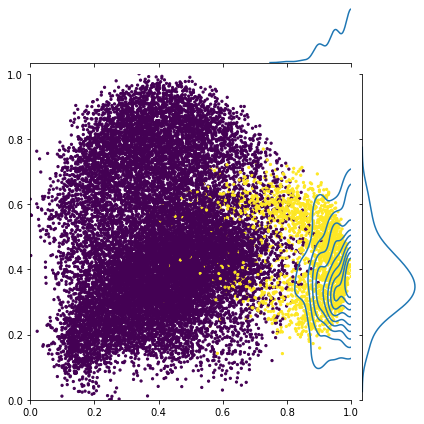

Starting Epoch :  19
Step 1: cost = 0.05162725943346316
Step 65: cost = 0.050474434190683724
Step 129: cost = 0.04934087418136146
Step 193: cost = 0.04822646125911948
Step 257: cost = 0.04713106698382945
Step 321: cost = 0.04605455322410383
Step 385: cost = 0.04499677274681306
Step 449: cost = 0.04395756979281079
Step 513: cost = 0.04293678063816801
Step 577: cost = 0.04193423414032349
Step 641: cost = 0.04094975226865798
Step 705: cost = 0.039983150619085084
Step 769: cost = 0.03903423891236319
Step 833: cost = 0.03810282147588122
Step 897: cost = 0.037188697708776926
Step 961: cost = 0.036291662530297635
Step 1025: cost = 0.03541150681138378
Step 1089: cost = 0.03454801778951349
Step 1153: cost = 0.03370097946690448
Step 1217: cost = 0.032870172992200755
Step 1281: cost = 0.0320553770258345
Step 1345: cost = 0.03125636808928989
Step 1409: cost = 0.030472920898504174
Step 1473: cost = 0.029704808681714594
Step 1537: cost = 0.028951803482041294
Step 1601: cost = 0.028213676445154982
St

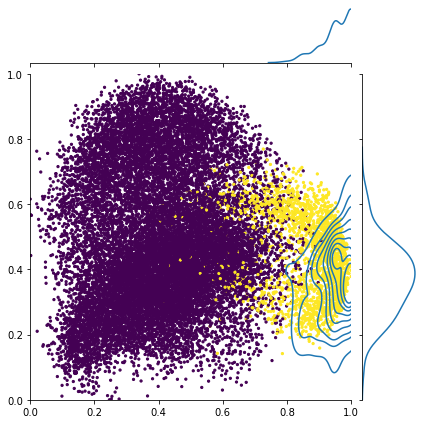

Starting Epoch :  20
Step 1: cost = 0.025141883735304196
Step 65: cost = 0.02447988556046199
Step 129: cost = 0.023831580904894123
Step 193: cost = 0.023196728235705733
Step 257: cost = 0.022575087440845465
Step 321: cost = 0.021966419986443858
Step 385: cost = 0.021370489063257336
Step 449: cost = 0.02078705972262665
Step 513: cost = 0.020215899002397286
Step 577: cost = 0.019656776043217937
Step 641: cost = 0.019109462195626037
Step 705: cost = 0.018573731118326275
Step 769: cost = 0.018049358868060486
Step 833: cost = 0.017536123981446217
Step 897: cost = 0.01703380754917294
Step 961: cost = 0.016542193282904183
Step 1025: cost = 0.01606106757525505
Step 1089: cost = 0.01559021955318085
Step 1153: cost = 0.015129441125110055
Step 1217: cost = 0.01467852702215211
Step 1281: cost = 0.014237274833681535
Step 1345: cost = 0.013805485037600929
Step 1409: cost = 0.01338296102558878
Step 1473: cost = 0.01296950912358208
Step 1537: cost = 0.012564938607791287
Step 1601: cost = 0.01216906171

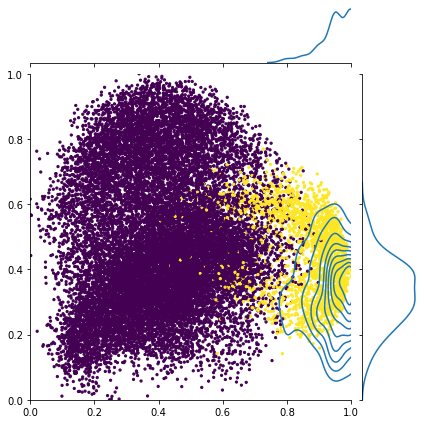

Starting Epoch :  21
Step 1: cost = 0.011027655765098787
Step 65: cost = 0.01068855004845215
Step 129: cost = 0.01035653189972352
Step 193: cost = 0.010031449994508668
Step 257: cost = 0.009713155641009719
Step 321: cost = 0.009401502762115377
Step 385: cost = 0.00909634787590008
Step 449: cost = 0.008797550074693072
Step 513: cost = 0.008504971002799677
Step 577: cost = 0.008218474833005196
Step 641: cost = 0.007937928241950387
Step 705: cost = 0.007663200384487423
Step 769: cost = 0.007394162867097154
Step 833: cost = 0.007130689720463934
Step 897: cost = 0.006872657371288837
Step 961: cost = 0.00661994461341886
Step 1025: cost = 0.006372432578364617
Step 1089: cost = 0.006130004705285352
Step 1153: cost = 0.0058925467104988805
Step 1217: cost = 0.005659946556585638
Step 1281: cost = 0.005432094421137901
Step 1345: cost = 0.0052088826652259
Step 1409: cost = 0.004990205801614023
Step 1473: cost = 0.004775960462793383
Step 1537: cost = 0.004566045368864846
Step 1601: cost = 0.00436036

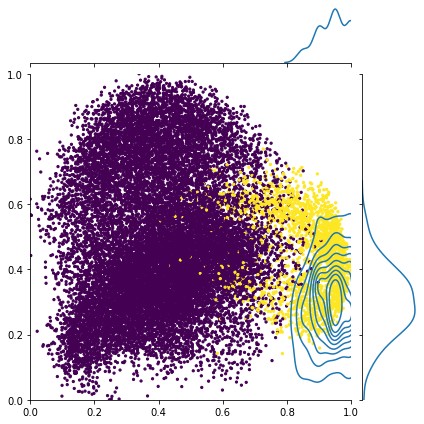

Starting Epoch :  22
Step 1: cost = 0.0044449530780967805
Step 65: cost = 0.004261748597052306
Step 129: cost = 0.004082036393931454
Step 193: cost = 0.0039057389913145224
Step 257: cost = 0.0037327804540912
Step 321: cost = 0.0035630863638159704
Step 385: cost = 0.003396583793222163
Step 449: cost = 0.0032332012809179744
Step 513: cost = 0.003072868806257012
Step 577: cost = 0.0029155177644192287
Step 641: cost = 0.0027610809416996895
Step 705: cost = 0.002609492491021159
Step 769: cost = 0.0024606879076805033
Step 833: cost = 0.0023146040053309003
Step 897: cost = 0.0021711788922240682
Step 961: cost = 0.0020303519476971843
Step 1025: cost = 0.0018920637989380262
Step 1089: cost = 0.001756256298009351
Step 1153: cost = 0.0016228724991508292
Step 1217: cost = 0.00149185663636775
Step 1281: cost = 0.001363154101294617
Step 1345: cost = 0.0012367114213569508
Step 1409: cost = 0.001112476238216531
Step 1473: cost = 0.0009903972865141775
Step 1537: cost = 0.0008704243729087402
Step 1601: 

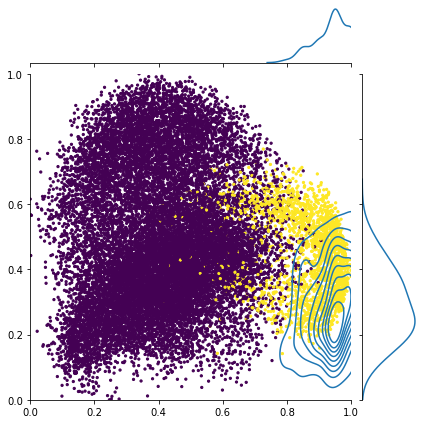

Starting Epoch :  23
Step 1: cost = 0.0013048530462086427
Step 65: cost = 0.0011931658839704484
Step 129: cost = 0.001083286757102342
Step 193: cost = 0.0009751752321204288
Step 257: cost = 0.0008687916795718786
Step 321: cost = 0.0007640972590450268
Step 385: cost = 0.0006610539044045183
Step 449: cost = 0.0005596243092422792
Step 513: cost = 0.00045977191256341143
Step 577: cost = 0.0003614608846796985
Step 641: cost = 0.0002646561133315961
Step 705: cost = 0.00016932319002715968
Step 769: cost = 7.542839660179546e-05
Step 833: cost = -1.706130801126804e-05
Step 897: cost = -0.0001081783007923498
Step 961: cost = -0.00019795430742985953
Step 1025: cost = -0.00028642041490833936
Step 1089: cost = -0.0003736070838865624
Step 1153: cost = -0.00045954416085969285
Step 1217: cost = -0.0005442608901251589
Step 1281: cost = -0.0006277859255399143
Step 1345: cost = -0.0007101473420736415
Step 1409: cost = -0.0007913726471646676
Step 1473: cost = -0.0008714887918761516
Step 1537: cost = -0.00

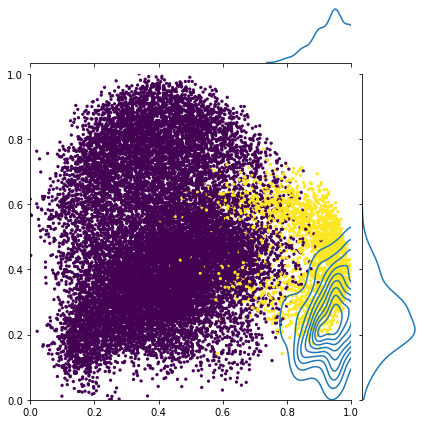

Starting Epoch :  24
Step 1: cost = -0.00033161360763656056
Step 65: cost = -0.0004096761676000149
Step 129: cost = -0.00048673152592537683
Step 193: cost = -0.0005628026914955564
Step 257: cost = -0.0006379122353695754
Step 321: cost = -0.0007120822989509223
Step 385: cost = -0.0007853346020214591
Step 449: cost = -0.0008576904506316652
Step 513: cost = -0.0009291707448655373
Step 577: cost = -0.0009997959864658235
Step 641: cost = -0.0010695862863332462
Step 705: cost = -0.0011385613718924992
Step 769: cost = -0.0012067405943303466
Step 833: cost = -0.0012741429357117084
Step 897: cost = -0.0013407870159666269
Step 961: cost = -0.0014066910997553306
Step 1025: cost = -0.0014718731032168364
Step 1089: cost = -0.0015363506005893202
Step 1153: cost = -0.0016001408307215748
Step 1217: cost = -0.001663260703463898
Step 1281: cost = -0.00172572680594274
Step 1345: cost = -0.0017875554087288803
Step 1409: cost = -0.001848762471886256
Step 1473: cost = -0.001909363650920426
Step 1537: cost =

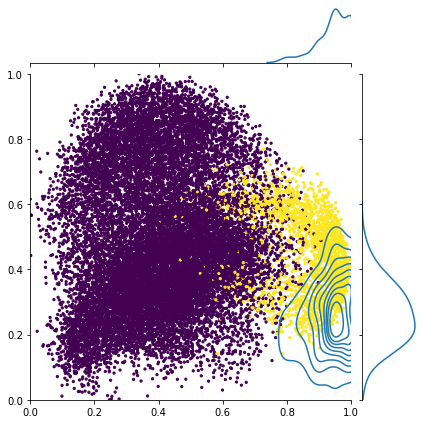

Starting Epoch :  25
Step 1: cost = -0.0013032105749314349
Step 65: cost = -0.0013650398895312943
Step 129: cost = -0.001426269805439584
Step 193: cost = -0.0014869148256774212
Step 257: cost = -0.0015469891940256275
Step 321: cost = -0.0016065068997020981
Step 385: cost = -0.001665481681951353
Step 449: cost = -0.0017239270345642543
Step 513: cost = -0.0017818562103140145
Step 577: cost = -0.0018392822253179286
Step 641: cost = -0.0018962178633274984
Step 705: cost = -0.0019526756799360667
Step 769: cost = -0.0020086680067209484
Step 833: cost = -0.002064206955310177
Step 897: cost = -0.00211930442138053
Step 961: cost = -0.0021739720885809444
Step 1025: cost = -0.0022282214323919858
Step 1089: cost = -0.0022820637239178154
Step 1153: cost = -0.0023355100336039936
Step 1217: cost = -0.0023885712349007715
Step 1281: cost = -0.002441258007854552
Step 1345: cost = -0.002493580842634957
Step 1409: cost = -0.00254555004300161
Step 1473: cost = -0.002597175729713408
Step 1537: cost = -0.002

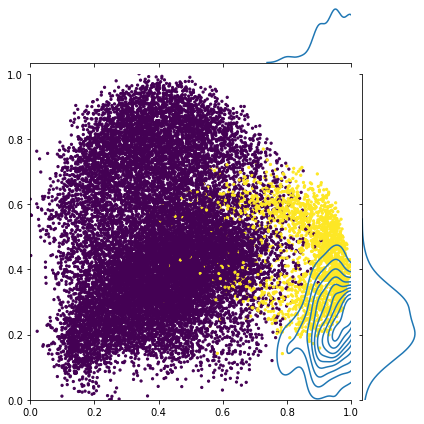

Starting Epoch :  26
Step 1: cost = -0.001983957775254619
Step 65: cost = -0.0020381177178747656
Step 129: cost = -0.0020919052399790417
Step 193: cost = -0.0021453304180194532
Step 257: cost = -0.0021984031609717514
Step 321: cost = -0.0022511332132164608
Step 385: cost = -0.002303530157367062
Step 449: cost = -0.002355603417057317
Step 513: cost = -0.002407362259673862
Step 577: cost = -0.0024588157990490522
Step 641: cost = -0.0025099729981064023
Step 705: cost = -0.002560842671460173
Step 769: cost = -0.0026114334879734358
Step 833: cost = -0.0026617539732705087
Step 897: cost = -0.0027118125122093106
Step 961: cost = -0.0027616173513107523
Step 1025: cost = -0.0028111766011416073
Step 1089: cost = -0.0028604982386697397
Step 1153: cost = -0.002909590109565041
Step 1217: cost = -0.002958459930467172
Step 1281: cost = -0.00300711529121922
Step 1345: cost = -0.00305556365705284
Step 1409: cost = -0.0031038123707434195
Step 1473: cost = -0.0031518686547264974
Step 1537: cost = -0.0031

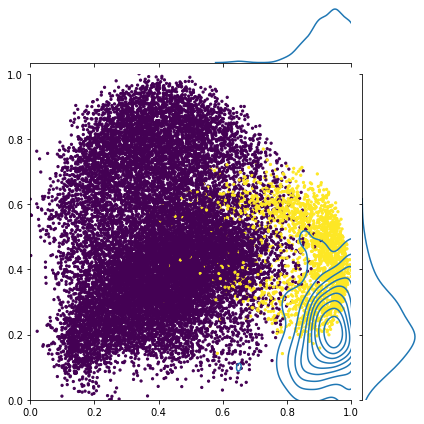

Starting Epoch :  27
Step 1: cost = -0.0025551732974440355
Step 65: cost = -0.002606288448378624
Step 129: cost = -0.0026571708739120403
Step 193: cost = -0.0027078281839200136
Step 257: cost = -0.0027582678714036524
Step 321: cost = -0.0028084973143979175
Step 385: cost = -0.0028585237778415706
Step 449: cost = -0.002908354415422365
Step 513: cost = -0.0029579962713882635
Step 577: cost = -0.0030074562823306783
Step 641: cost = -0.0030567412789411774
Step 705: cost = -0.003105857987736216
Step 769: cost = -0.0031548130327549995
Step 833: cost = -0.003203612937230038
Step 897: cost = -0.0032522641252309414
Step 961: cost = -0.0033007729232795713
Step 1025: cost = -0.003349145561942768
Step 1089: cost = -0.0033973881773899928
Step 1153: cost = -0.003445506812939203
Step 1217: cost = -0.0034935074205648675
Step 1281: cost = -0.003541395862386665
Step 1345: cost = -0.003589177912137309
Step 1409: cost = -0.003636859256595848
Step 1473: cost = -0.003684445497007971
Step 1537: cost = -0.003

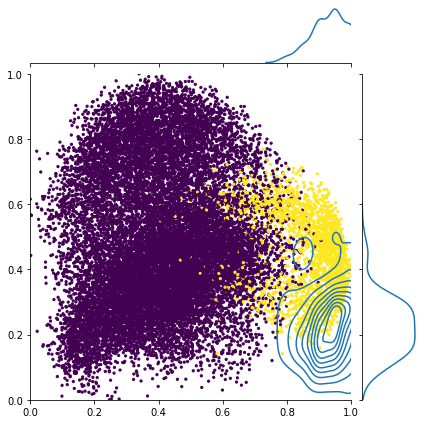

Starting Epoch :  28
Step 1: cost = -0.0031155951955170735
Step 65: cost = -0.003166431486916199
Step 129: cost = -0.003217130693839554
Step 193: cost = -0.003267698954930731
Step 257: cost = -0.003318142321973472
Step 321: cost = -0.0033684667612291497
Step 385: cost = -0.0034186781547548284
Step 449: cost = -0.00346878230169978
Step 513: cost = -0.003518784919579354
Step 577: cost = -0.003568691645537303
Step 641: cost = -0.003618508037576018
Step 705: cost = -0.003668239575781107
Step 769: cost = -0.003717891663516104
Step 833: cost = -0.003767469628603415
Step 897: cost = -0.0038169787244884956
Step 961: cost = -0.003866424131379609
Step 1025: cost = -0.003915810957378918
Step 1089: cost = -0.003965144239585716
Step 1153: cost = -0.0040144289451919946
Step 1217: cost = -0.004063669972552697
Step 1281: cost = -0.0041128721522473155
Step 1345: cost = -0.004162040248116061
Step 1409: cost = -0.004211178958288597
Step 1473: cost = -0.004260292916188235
Step 1537: cost = -0.004309386691

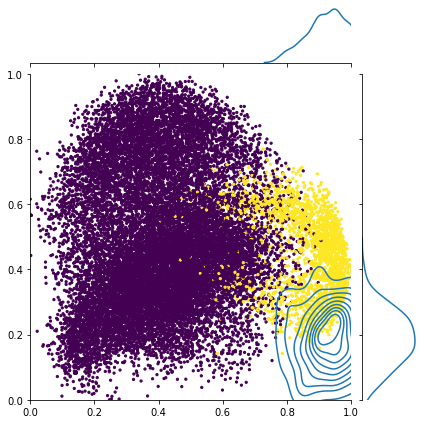

Starting Epoch :  29
Step 1: cost = -0.0037252921502315406
Step 65: cost = -0.0037776629136277995
Step 129: cost = -0.0038299688071600224
Step 193: cost = -0.0038822150271504707
Step 257: cost = -0.003934406702138404
Step 321: cost = -0.003986548893867847
Step 385: cost = -0.004038646598264917
Step 449: cost = -0.004090704746396168
Step 513: cost = -0.004142728205415169
Step 577: cost = -0.004194721779491539
Step 641: cost = -0.004246690210733206
Step 705: cost = -0.004298638180088354
Step 769: cost = -0.004350570308236268
Step 833: cost = -0.004402491156467958
Step 897: cost = -0.004454405227548364
Step 961: cost = -0.004506316966570556
Step 1025: cost = -0.004558230761796733
Step 1089: cost = -0.004610150945482339


KeyboardInterrupt: 

In [19]:
# trainin cycle loop:
# dev.shots = 10
# learning_rate = 0.1
generator_cost = []
dis_cost = []
epochs = 100
for ep in range(epochs):
    print("Starting Epoch : ", ep)
    
    # Train the discriminator first, lock the generator variables:
    disc_weights.requires_grad = True
    gen_weights.requires_grad = False
    for i in range(0, len(pca_data), batch_size):
        if i + batch_size >= len(pca_data):
            x_in_l = np.array(pca_data[i: len(pca_data)], requires_grad=False)
        else:
            x_in_l = np.array(pca_data[i: i+batch_size], requires_grad=False)
            
        x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
        cost = disc_cost(x_in_l, gen_weights, disc_weights)
        dis_cost.append(cost)
        print("Step {}: cost = {}".format(i + 1, cost))
#     for i in range(len(pca_data)):
#         x_in_l = np.array(pca_data[i], requires_grad=False)
#         x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
#         cost = disc_cost(x_in_l,gen_weights, disc_weights)
#         if i % batch_size == 0:
            
#             print("Step {}: cost = {}".format(i + 1, cost))
    test_ind = random.randrange(len(pca_data) - batch_size)        
    test_x = pca_data[test_ind: test_ind + batch_size]
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    
    print("Generator Training starting......")
    # Train the Generator next, lock the discriminator variables:
    disc_weights.requires_grad = False
    gen_weights.requires_grad = True   
    for j in range(0, len(pca_data), batch_size):
        gen_weights, disc_weights = opt.step(gen_cost, gen_weights, disc_weights)
#         gradient = qml.gradients.param_shift(gen_disc_circuit)(gen_weights, disc_weights)
#         gen_weights = update_weights(gen_weights, learning_rate, gradient, True)
        cost = gen_cost(gen_weights, disc_weights)
        generator_cost.append(cost)
#         if i % batch_size == 0:
        print("Step {}: cost = {}".format(j + 1, cost))
            
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    print("Disc Cost = ", disc_cost(test_x, gen_weights, disc_weights))
    # generate distribution graph
    gen_datas = []
    for _ in range(100):
        res = gen_data(gen_weights)
        result = []
        for i in range(len(res)): 
            result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
        gen_datas.append(result)
   
    # Shuffle Input data    
    random.shuffle(pca_data)
    
    generated_data = np.array(gen_datas)
    graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
    graph.x = X[:,0]
    graph.y = X[:,1]
    graph.plot_joint(plt.scatter, marker='o', c=valid_labels, s=5)
    plt.show()

In [ ]:
# Exract Synthetic data from Generator:
gen_dev.shots= 19
gen_datas = []
for _ in range(100):
    res = gen_data(gen_weights)
    result = []
    for i in range(len(res)): 
        result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
    print(result)
    gen_datas.append(result)

In [ ]:
synthetic_points = scaler.inverse_transform(np.array(gen_datas))
synthetic_points = pca.inverse_transform(synthetic_points)

In [ ]:
def generate_and_save_images(synthetic_data):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    fig = plt.figure(figsize=(4,4))
    
    for i in range(synthetic_data.shape[0]):
        plt.subplot(10, 10, i+1)
        dp = np.array((synthetic_data[i] * 127.5) + 127.5).astype('uint8').reshape(imsize,imsize)
        plt.imshow(dp,cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(1010))
    plt.show()

In [ ]:
generate_and_save_images(synthetic_points)

#### CSwap Test for real and generated data

In [ ]:
test_dev = qml.device("default.qubit", wires=2 * k + 1)

def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires=i)
        
@qml.qnode(test_dev)
def cswap_test(x_in_l, gen_weights):
    qml.Hadamard(wires= 2 * k)
        
    generator(gen_weights)
    real(x_in_l)
    
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
        
    return qml.probs(wires= 2 * k)

In [ ]:
drawer = qml.draw(cswap_test,max_length=100)
print(drawer(x_in[0], gen_weights))

In [ ]:
test_dev.shots = 2048
avg_fid = 0
for rot_data in pca_data:
    avg_fid += cswap_test(rot_data, gen_weights)
print("Avg_Fidelity : ", avg_fid / len(pca_data))

In [ ]:
import seaborn as sns
generated_data = np.array(gen_datas)
graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
graph.x = X[:,0]
graph.y = X[:,1]
graph.plot_joint(plt.scatter, marker='o', c=train_labels, s=5)
plt.show()